# Molecule Class Examples

This notebook demonstrates the **Molecule** class from iSLAT, which is the primary high-level abstraction for working with molecular spectroscopy data. It integrates and coordinates three core components:

- **MoleculeLineList** — HITRAN/HITEMP line data (wavelengths, line strengths, energy levels)
- **Intensity** — Line intensity and optical depth calculations
- **Spectrum** — Flux spectra with line broadening and convolution

## Key Features Demonstrated:
1. **Creating Molecule Instances** — Initialize molecules with physical parameters
2. **Accessing Internal Objects** — Access MoleculeLineList, Intensity, and Spectrum objects
3. **Using get_flux()** — The primary interface for getting model spectra
4. **Parameter Modification** — Change parameters with automatic cache invalidation
5. **Bulk Updates** — Efficiently update multiple parameters at once
6. **Radial Velocity Shifts** — Apply Doppler shifts to spectra
7. **Thermal Broadening** — Automatic calculation based on temperature and mass
8. **Cache Management** — Inspect and control internal caching for performance
9. **Multi-Molecule Modeling** — Combine spectra from multiple molecules

In [38]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
# Go up from DataTypes -> Notebooks -> Examples -> iSLATTests
islat_root = notebook_dir.parent.parent.parent
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

# Import data types from iSLAT
from iSLAT.Modules.DataTypes import Molecule, MoleculeLineList, Intensity, Spectrum

print("iSLAT data types imported successfully!")

iSLAT data types imported successfully!


In [39]:
# Define paths to HITRAN parameter files for the molecules we want to create
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"

water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")
hcn_par_file   = str(data_dir / "data_Hitran_HCN.par")

## 1. Creating a Molecule Instance

The `Molecule` class is the primary way to work with molecular spectra. Specify the molecule name (which auto-loads the corresponding HITRAN data) along with physical parameters like temperature, column density, and wavelength range.

In [40]:
# Basic creation with default parameters
h2o = Molecule(
    name="H2O",
    filepath=water_par_file,     # Path to HITRAN data file
    temp=500.0,                  # Temperature in Kelvin
    n_mol=1e18,                  # Column density (molecules/cm^2)
    radius=1.0,                  # Emitting radius in AU
    distance=140.0,              # Distance in parsecs
    wavelength_range=(14.0, 18.0)  # Wavelength range in microns
)

print(h2o)
print(f"\nMolecule name: {h2o.name}")
print(f"Temperature: {h2o.temp} K")
print(f"Column density: {h2o.n_mol:.2e} molecules/cm^2")
print(f"Radius: {h2o.radius} AU")
print(f"Distance: {h2o.distance} pc")

Molecule(name=H2O, temp=500.0, radius=1.0, n_mol=1e+18)

Molecule name: H2O
Temperature: 500.0 K
Column density: 1.00e+18 molecules/cm^2
Radius: 1.0 AU
Distance: 140.0 pc


In [41]:
# Creating a molecule with more detailed parameters
co = Molecule(
    name="CO",
    filepath=co_par_file,        # Path to HITRAN data file
    temp=800.0,
    n_mol=1e17,
    radius=0.5,
    distance=140.0,
    wavelength_range=(4.5, 5.2),
    fwhm=10.0,                   # Instrument FWHM in km/s
    broad=2.0,                   # Additional broadening in km/s
    rv_shift=5.0,                # Radial velocity shift in km/s
    model_pixel_res=0.00001      # Model pixel resolution
)

print(co)
print(f"\nInstrument FWHM: {co.fwhm} km/s")
print(f"Additional broadening: {co.broad} km/s")
print(f"RV shift: {co.rv_shift} km/s")

Molecule(name=CO, temp=800.0, radius=0.5, n_mol=1e+17)

Instrument FWHM: 10.0 km/s
Additional broadening: 1.0 km/s
RV shift: 5.0 km/s


## 2. Accessing the MoleculeLineList

The Molecule class internally uses a `MoleculeLineList` to manage the HITRAN line data. Access it through the `lines` property to inspect or analyze the raw spectral line data.

In [42]:
# Access the internal MoleculeLineList
lines = h2o.line_list

print(f"Type: {type(lines)}")
print(f"\nNumber of lines: {len(lines)}")
print(f"Molar mass: {lines.molar_mass} g/mol")
print(f"HITRAN molecule ID: {lines.molecule_id}")
print(f"Wavelength range: {lines.get_wavelengths().min():.4f} - {lines.get_wavelengths().max():.4f} um")

Type: <class 'iSLAT.Modules.DataTypes.MoleculeLineList.MoleculeLineList'>

Number of lines: 305561
Molar mass: 18.010565 g/mol
HITRAN molecule ID: H2O
Wavelength range: 0.3000 - 933.2766 um


In [43]:
# Access line data arrays directly through the MoleculeLineList
print("Line data arrays available through molecule.lines:")
print(f"  - wavelengths: {lines.get_wavelengths().shape}")
print(f"  - frequencies: {lines.get_frequencies().shape}")
print(f"  - einstein_a_coeffs: {lines.get_einstein_coefficients().shape}")
print(f"  - lower_energies: {lines.get_lower_energies().shape}")
print(f"  - upper_energies: {lines.get_upper_energies().shape}")

# Show first 5 lines
print("\nFirst 5 lines (wavelength, Einstein A, E_lower):")
wavelengths = lines.get_wavelengths()
einstein_a = lines.get_einstein_coefficients()
e_lower = lines.get_lower_energies()
for i in range(min(5, len(lines))):
    print(f"  {wavelengths[i]:.5f} um, A = {einstein_a[i]:.3e}, E'' = {e_lower[i]:.2f} cm^-1")

Line data arrays available through molecule.lines:
  - wavelengths: (305561,)
  - frequencies: (305561,)
  - einstein_a_coeffs: (305561,)
  - lower_energies: (305561,)
  - upper_energies: (305561,)

First 5 lines (wavelength, Einstein A, E_lower):
  933.27661 um, A = 6.177e-06, E'' = 1845.83 cm^-1
  928.22180 um, A = 8.967e-06, E'' = 5850.24 cm^-1
  926.64453 um, A = 2.590e-05, E'' = 6023.54 cm^-1
  926.56085 um, A = 9.288e-06, E'' = 6005.51 cm^-1
  922.00464 um, A = 1.157e-05, E'' = 454.34 cm^-1


In [44]:
# Convert line data to pandas DataFrame for analysis
df = lines.get_pandas_table()
print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
display(df.head(10))

DataFrame shape: (305561, 10)

Columns: ['nr', 'lev_up', 'lev_low', 'lam', 'freq', 'a_stein', 'e_up', 'e_low', 'g_up', 'g_low']


,nr,lev_up,lev_low,lam,freq,a_stein,e_up,e_low,g_up,g_low
0,0,0_0_0|10_2_9,0_0_0|9_3_6,933.27661,3.212257e+11,0.000006,1861.25073,1845.83411,63,57
1,1,0_0_1|5_1_5,0_0_1|4_2_2,928.22180,3.229750e+11,0.000009,5865.74316,5850.24268,33,27
2,2,0_2_0|6_5_1,0_2_0|7_4_4,926.64453,3.235247e+11,0.000026,6039.06494,6023.53857,13,15
3,3,0_1_0|14_3_12,0_1_0|13_4_9,926.56085,3.235540e+11,0.000009,6021.03809,6005.50977,87,81
4,4,0_0_0|5_1_5,0_0_0|4_2_2,922.00464,3.251529e+11,0.000012,469.94110,454.33624,11,9
5,5,1_0_0|5_1_5,1_0_0|4_2_2,917.67560,3.266867e+11,0.000010,5722.67236,5706.99365,11,9
6,6,0_2_0|3_2_1,0_2_0|4_1_4,905.37897,3.311237e+11,0.000033,4881.40918,4865.51709,21,27
7,7,0_1_0|5_2_3,0_1_0|6_1_6,891.63464,3.362279e+11,0.000011,2955.20264,2939.06616,33,39
8,8,0_0_0|16_6_11,0_0_0|17_3_14,884.22882,3.390440e+11,0.000008,5499.35889,5483.08691,99,105
9,9,0_0_0|17_4_13,0_0_0|16_7_10,844.94141,3.548086e+11,0.000009,5780.87305,5763.84570,105,99


## 3. Accessing the Intensity Object

The Molecule class calculates line intensities using the `Intensity` class. Once intensities are computed (triggered automatically when getting flux), access the internal Intensity object through the `intensity` property.

In [45]:
# Force calculation of intensity (this happens automatically when getting flux)
h2o.get_flux()  # This will trigger intensity calculation if not already done
# Access the internal intensity object
intensity_obj = h2o.intensity

print(f"Type: {type(intensity_obj)}")
print(f"\nIntensity object attributes:")
print(f"  - Temperature: {intensity_obj.t_kin} K")
print(f"  - Number of lines: {len(intensity_obj.molecule.get_wavelengths())}")

Calculating intensity for H2O: T=500.0K, N_mol=1.00e+18, dv=1.0
Type: <class 'iSLAT.Modules.DataTypes.Intensity.Intensity'>

Intensity object attributes:
  - Temperature: 500.0 K
  - Number of lines: 305561
Type: <class 'iSLAT.Modules.DataTypes.Intensity.Intensity'>

Intensity object attributes:
  - Temperature: 500.0 K
  - Number of lines: 305561


Intensity calculation results:
  - Wavelengths: (305561,)
  - Line intensities: (305561,)
  - Optical depths (tau): (305561,)


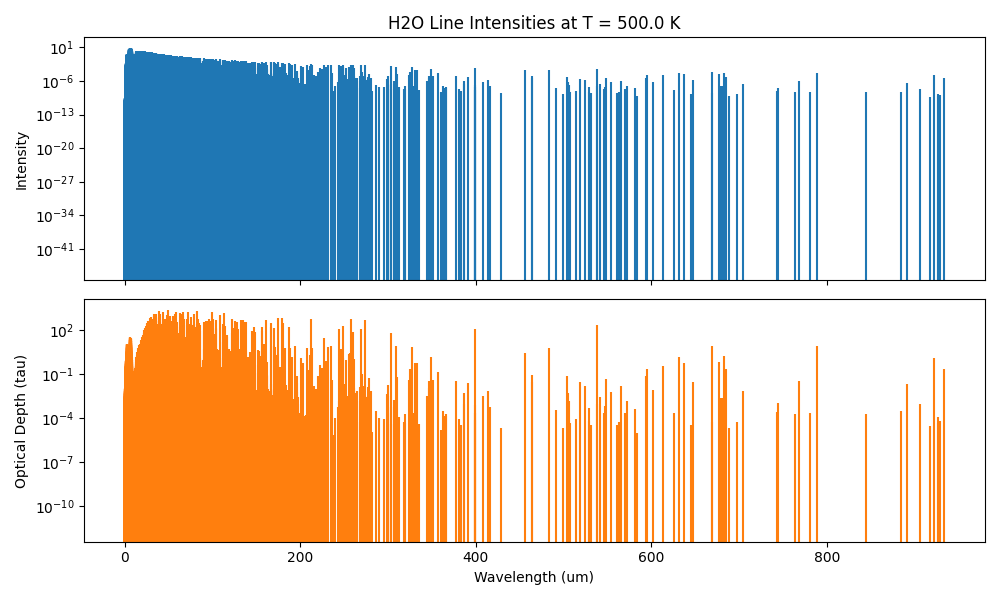

In [46]:
# Access intensity calculation results
wavelengths = intensity_obj.molecule.get_wavelengths()
print("Intensity calculation results:")
print(f"  - Wavelengths: {wavelengths.shape}")
print(f"  - Line intensities: {intensity_obj.intensity.shape}")
print(f"  - Optical depths (tau): {intensity_obj.tau.shape}")

# Plot line intensities
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.stem(wavelengths, intensity_obj.intensity, markerfmt=' ', basefmt=' ')
ax1.set_ylabel('Intensity')
ax1.set_title(f'H2O Line Intensities at T = {h2o.temp} K')
ax1.set_yscale('log')

ax2.stem(wavelengths, intensity_obj.tau, markerfmt=' ', basefmt=' ', linefmt='C1-')
ax2.set_xlabel('Wavelength (um)')
ax2.set_ylabel('Optical Depth (tau)')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## 4. Accessing the Spectrum Object

The Molecule class generates flux spectra using the `Spectrum` class, which applies line broadening and instrument convolution. Access it through the `spectrum` property.

In [47]:
# Access the internal Spectrum object
spectrum_obj = h2o.spectrum

print(f"Type: {type(spectrum_obj)}")
print(f"\nSpectrum object attributes:")
print(f"  - Wavelength grid: {spectrum_obj.lamgrid.shape}")
print(f"  - Flux array: {spectrum_obj.flux.shape}")

Type: <class 'iSLAT.Modules.DataTypes.Spectrum.Spectrum'>

Spectrum object attributes:
  - Wavelength grid: (5677,)
  - Flux array: (5677,)


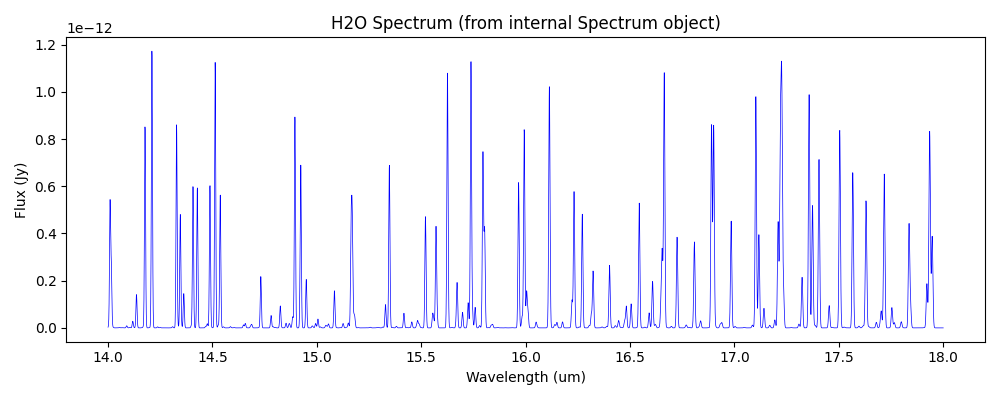

In [48]:
# Plot the spectrum from the internal Spectrum object
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(spectrum_obj.lamgrid, spectrum_obj.flux, 'b-', lw=0.5)
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Flux (Jy)')
ax.set_title(f'H2O Spectrum (from internal Spectrum object)')

plt.tight_layout()
plt.show()

## 5. Using get_flux() - The Primary Interface

The `get_flux()` method is the main way to retrieve model spectra from a Molecule. It handles all internal calculations and returns flux on either the native or a custom wavelength grid.

In [49]:
# Get flux on native wavelength grid
wavelengths, flux = h2o.get_flux(return_wavelengths=True)

print(f"Native grid results:")
print(f"  Wavelength array shape: {wavelengths.shape}")
print(f"  Flux array shape: {flux.shape}")
print(f"  Wavelength range: {wavelengths.min():.4f} - {wavelengths.max():.4f} um")
print(f"  Max flux: {flux.max():.4e} Jy")

Native grid results:
  Wavelength array shape: (5677,)
  Flux array shape: (5677,)
  Wavelength range: 14.0000 - 18.0000 um
  Max flux: 1.1186e-01 Jy


In [50]:
# Get flux interpolated to a custom wavelength grid
custom_wavelengths = np.linspace(15.0, 17.0, 2000)
custom_flux = h2o.get_flux(
    wavelength_array=custom_wavelengths,
    interpolate_to_input=True
)

print(f"Custom grid results:")
print(f"  Requested wavelength range: {custom_wavelengths.min():.2f} - {custom_wavelengths.max():.2f} um")
print(f"  Flux array shape: {custom_flux.shape}")

Custom grid results:
  Requested wavelength range: 15.00 - 17.00 um
  Flux array shape: (2000,)


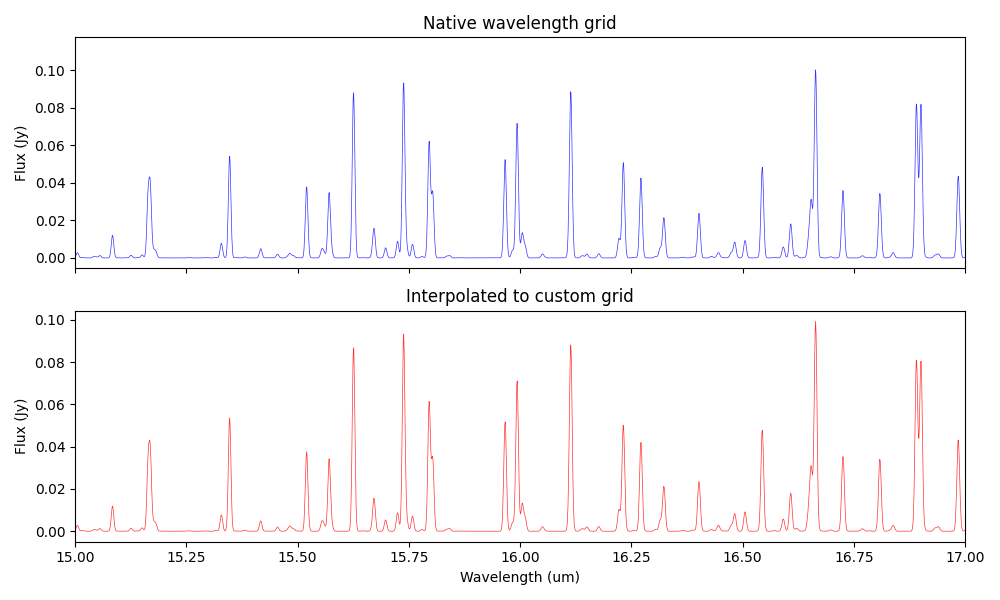

In [51]:
# Compare native vs interpolated grids
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Native grid
ax1.plot(wavelengths, flux, 'b-', lw=0.5, alpha=0.8)
ax1.set_ylabel('Flux (Jy)')
ax1.set_title('Native wavelength grid')
ax1.set_xlim(15, 17)

# Interpolated grid
ax2.plot(custom_wavelengths, custom_flux, 'r-', lw=0.5, alpha=0.8)
ax2.set_xlabel('Wavelength (um)')
ax2.set_ylabel('Flux (Jy)')
ax2.set_title('Interpolated to custom grid')

plt.tight_layout()
plt.show()

## 6. Parameter Modification and Caching

The Molecule class uses intelligent caching. When you change a parameter, only the necessary calculations are invalidated and recalculated on the next access.

In [52]:
# Check initial cache status
print("Initial cache status:")
print(f"  Intensity cache valid: {h2o.is_cache_valid('intensity')}")
print(f"  Spectrum cache valid: {h2o.is_cache_valid('spectrum')}")
print(f"  Flux cache valid: {h2o.is_cache_valid('flux')}")
print(f"\nCache stats: {h2o.get_cache_stats()}")

Initial cache status:
  Intensity cache valid: True
  Spectrum cache valid: True
  Flux cache valid: True

Cache stats: {'hits': 1, 'misses': 4, 'invalidations': 0}


In [53]:
# Change temperature (affects intensity calculation)
print(f"Changing temperature from {h2o.temp} K to 700 K...")
h2o.temp = 700.0

print("\nCache status after temp change:")
print(f"  Intensity cache valid: {h2o.is_cache_valid('intensity')}")
print(f"  Spectrum cache valid: {h2o.is_cache_valid('spectrum')}")

# Get flux - this triggers recalculation
_, new_flux = h2o.get_flux(return_wavelengths=True)
print(f"\nCache status after getting flux:")
print(f"  Cache stats: {h2o.get_cache_stats()}")

Changing temperature from 500.0 K to 700 K...

Cache status after temp change:
  Intensity cache valid: False
  Spectrum cache valid: False
Calculating intensity for H2O: T=700.0K, N_mol=1.00e+18, dv=1.0

Cache status after getting flux:
  Cache stats: {'hits': 1, 'misses': 7, 'invalidations': 0}

Cache status after getting flux:
  Cache stats: {'hits': 1, 'misses': 7, 'invalidations': 0}


## 7. Bulk Parameter Updates

When changing multiple parameters at once, use `bulk_update_parameters()` for better efficiency. This minimizes cache invalidation overhead compared to setting each parameter individually.

In [54]:
# Create a fresh molecule for bulk update demo
mol = Molecule(
    name="CO2",
    filepath=co2_par_file,
    temp=400.0,
    n_mol=1e17,
    radius=1.0,
    distance=140.0,
    wavelength_range=(13.5, 16.5)
)

print(f"Before bulk update:")
print(f"  Temperature: {mol.temp} K")
print(f"  Column density: {mol.n_mol:.2e}")
print(f"  Radius: {mol.radius} AU")
print(f"  FWHM: {mol.fwhm} km/s")

Before bulk update:
  Temperature: 400.0 K
  Column density: 1.00e+17
  Radius: 1.0 AU
  FWHM: 130.0 km/s


In [55]:
# Bulk update multiple parameters at once
mol.bulk_update_parameters({
    'temp': 600.0,
    'n_mol': 5e17,
    'radius': 0.5,
    'fwhm': 15.0,
    'broad': 3.0
})

print(f"After bulk update:")
print(f"  Temperature: {mol.temp} K")
print(f"  Column density: {mol.n_mol:.2e}")
print(f"  Radius: {mol.radius} AU")
print(f"  FWHM: {mol.fwhm} km/s")
print(f"  Broadening: {mol.broad} km/s")

After bulk update:
  Temperature: 600.0 K
  Column density: 5.00e+17
  Radius: 0.5 AU
  FWHM: 15.0 km/s
  Broadening: 3.0 km/s


## 8. Radial Velocity Shifts

The Molecule class supports radial velocity (RV) shifts, which shift the spectrum in wavelength space to simulate Doppler effects from source motion.

Calculating intensity for H2O: T=500.0K, N_mol=1.00e+18, dv=1.0
Applying RV shift of -20.0 km/s for molecule H2O
Applying RV shift of -10.0 km/s for molecule H2O
Applying RV shift of 10.0 km/s for molecule H2O
Applying RV shift of 20.0 km/s for molecule H2O
Applying RV shift of -20.0 km/s for molecule H2O
Applying RV shift of -10.0 km/s for molecule H2O
Applying RV shift of 10.0 km/s for molecule H2O
Applying RV shift of 20.0 km/s for molecule H2O


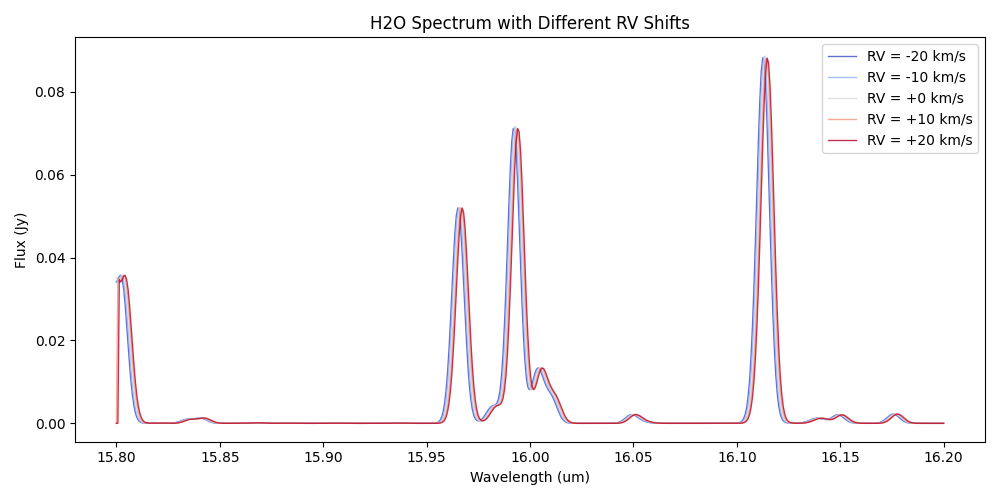

In [63]:
# Create molecule for RV shift demo
h2o_rv = Molecule(
    name="H2O",
    filepath=water_par_file,
    temp=500.0,
    n_mol=1e18,
    radius=1.0,
    distance=140.0,
    wavelength_range=(15.8, 16.2),
    rv_shift=0.0  # Start with no shift
)

fig, ax = plt.subplots(figsize=(10, 5))

rv_shifts = [-20, -10, 0, 10, 20]  # km/s
colors = plt.cm.coolwarm(np.linspace(0, 1, len(rv_shifts)))

for rv, color in zip(rv_shifts, colors):
    h2o_rv.rv_shift = rv
    wl, fl = h2o_rv.get_flux(return_wavelengths=True)
    ax.plot(wl, fl, color=color, lw=1, alpha=0.8, label=f'RV = {rv:+d} km/s')

ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Flux (Jy)')
ax.set_title('H2O Spectrum with Different RV Shifts')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 9. Thermal Broadening

The Molecule class automatically calculates thermal broadening based on temperature and molecular mass. Lighter molecules have broader lines at the same temperature.

In [57]:
# Compare thermal broadening for different molecules
# Define molecules with their par files
molecules_info = [
    ("H2O", water_par_file),
    ("CO", co_par_file),
    ("CO2", co2_par_file),
]

temp = 500.0
print(f"Thermal broadening at T = {temp} K:\n")

for name, par_file in molecules_info:
    mol = Molecule(
        name=name,
        filepath=par_file,
        temp=temp,
        n_mol=1e17,
        radius=1.0,
        distance=140.0,
        wavelength_range=(4.5, 5.0) if name == "CO" else (13.5, 16.0)
    )
    
    print(f"  {name:5s}:")
    print(f"    Molar mass: {mol.molar_mass:.3f} g/mol")
    print(f"    Thermal broadening: {mol.thermal_broad:.4f} km/s")
    print()

Thermal broadening at T = 500.0 K:

  H2O  :
    Molar mass: 18.011 g/mol
    Thermal broadening: 0.4804 km/s

  CO   :
    Molar mass: 27.995 g/mol
    Thermal broadening: 0.3854 km/s

  CO2  :
    Molar mass: 43.990 g/mol
    Thermal broadening: 0.3074 km/s



## 10. Cache Management

The Molecule class provides methods to inspect and manage caches. This is useful for debugging, understanding performance, and forcing recalculation when needed.

In [58]:
# Create a molecule and perform some operations
mol = Molecule(
    name="HCN",
    filepath=hcn_par_file,
    temp=500.0,
    n_mol=1e17,
    radius=1.0,
    distance=140.0,
    wavelength_range=(13.5, 14.5)
)

# Perform several flux calculations
_ = mol.get_flux()  # First calculation
_ = mol.get_flux()  # Cache hit
mol.temp = 600.0
_ = mol.get_flux()  # Cache miss (temp changed)
_ = mol.get_flux()  # Cache hit

print("Cache statistics:")
stats = mol.get_cache_stats()
for key, value in stats.items():
    print(f"  {key}: {value}")

print(f"\nCache validity:")
print(f"  Full cache valid: {mol.is_cache_valid('full')}")
print(f"  Intensity cache valid: {mol.is_cache_valid('intensity')}")
print(f"  Spectrum cache valid: {mol.is_cache_valid('spectrum')}")

Calculating intensity for HCN: T=500.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for HCN: T=600.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for HCN: T=600.0K, N_mol=1.00e+17, dv=1.0
Cache statistics:
  hits: 2
  misses: 6
  invalidations: 0

Cache validity:
  Full cache valid: True
  Intensity cache valid: True
  Spectrum cache valid: True
Cache statistics:
  hits: 2
  misses: 6
  invalidations: 0

Cache validity:
  Full cache valid: True
  Intensity cache valid: True
  Spectrum cache valid: True


In [59]:
# Clear all caches
print("Clearing all caches...")
mol.clear_all_caches()

print(f"\nAfter clearing:")
print(f"  Cache stats: {mol.get_cache_stats()}")
print(f"  Full cache valid: {mol.is_cache_valid('full')}")

Clearing all caches...

After clearing:
  Cache stats: {'hits': 2, 'misses': 6, 'invalidations': 1}
  Full cache valid: False


In [60]:
# Force recalculation of everything
print("Forcing full recalculation...")
mol.force_recalculate()

print(f"\nAfter force_recalculate:")
print(f"  Intensity cache valid: {mol.is_cache_valid('intensity')}")
print(f"  Spectrum cache valid: {mol.is_cache_valid('spectrum')}")

Forcing full recalculation...
Calculating intensity for HCN: T=600.0K, N_mol=1.00e+17, dv=1.0

After force_recalculate:
  Intensity cache valid: True
  Spectrum cache valid: True


## 11. Working with Multiple Molecules

You can create multiple Molecule instances and combine their spectra for multi-component modeling. Interpolate all molecules to a common wavelength grid for accurate summing.

In [61]:
# Create multiple molecules with the same wavelength grid
wavelength_range = (13.5, 17.0)
common_wl = np.linspace(13.5, 17.0, 5000)

molecules = {
    'H2O': Molecule(
        name="H2O", filepath=water_par_file, temp=500.0, n_mol=1e18, radius=1.0, distance=140.0,
        wavelength_range=wavelength_range
    ),
    'CO2': Molecule(
        name="CO2", filepath=co2_par_file, temp=450.0, n_mol=5e17, radius=1.0, distance=140.0,
        wavelength_range=wavelength_range
    ),
    'HCN': Molecule(
        name="HCN", filepath=hcn_par_file, temp=600.0, n_mol=2e16, radius=0.8, distance=140.0,
        wavelength_range=wavelength_range
    )
}

print(f"Created {len(molecules)} molecules:")
for name, mol in molecules.items():
    print(f"  {name}: T={mol.temp}K, N={mol.n_mol:.1e}")

Created 3 molecules:
  H2O: T=500.0K, N=1.0e+18
  CO2: T=450.0K, N=5.0e+17
  HCN: T=600.0K, N=2.0e+16


Calculating intensity for H2O: T=500.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=450.0K, N_mol=5.00e+17, dv=1.0
Calculating intensity for CO2: T=450.0K, N_mol=5.00e+17, dv=1.0
Calculating intensity for HCN: T=600.0K, N_mol=2.00e+16, dv=1.0
Calculating intensity for HCN: T=600.0K, N_mol=2.00e+16, dv=1.0


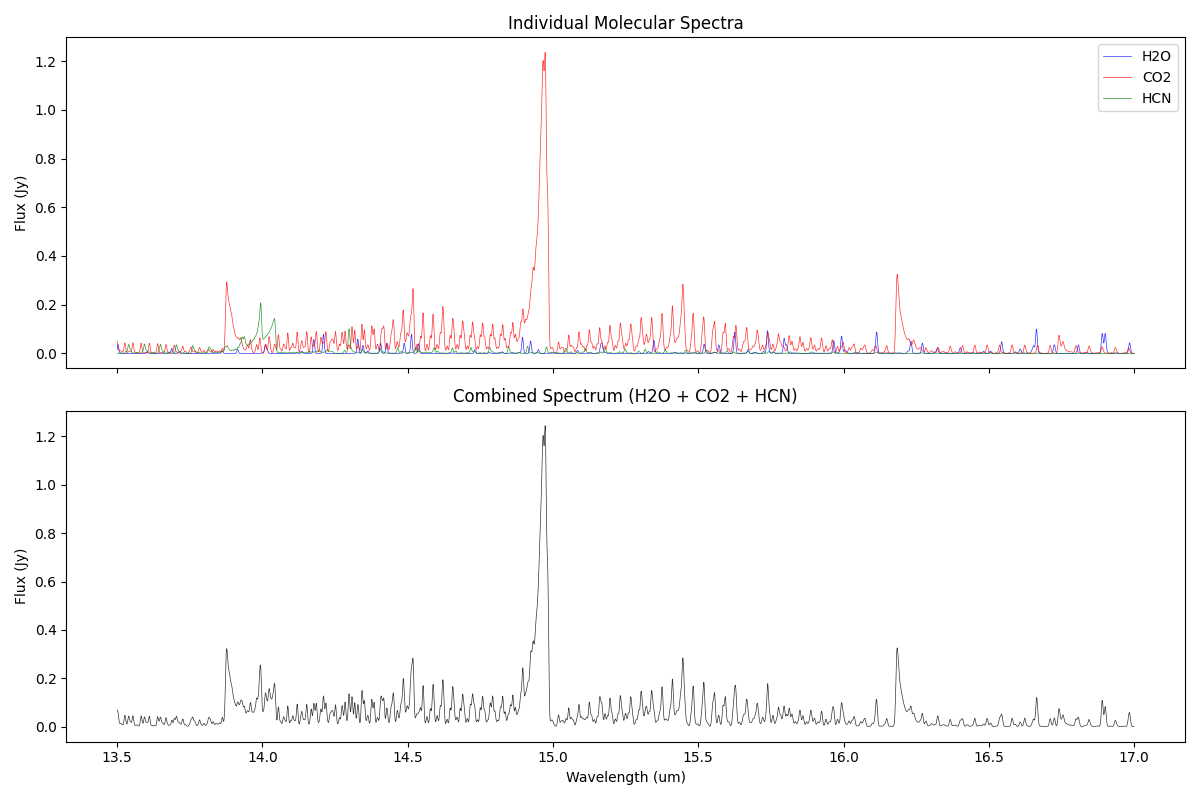

In [62]:
# Get flux for each molecule on the common wavelength grid
fluxes = {}
for name, mol in molecules.items():
    fluxes[name] = mol.get_flux(wavelength_array=common_wl, interpolate_to_input=True)

# Calculate total flux
total_flux = sum(fluxes.values())

# Plot individual and combined spectra
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

colors = {'H2O': 'blue', 'CO2': 'red', 'HCN': 'green'}

# Individual spectra
for name, flux in fluxes.items():
    ax1.plot(common_wl, flux, color=colors[name], lw=0.5, alpha=0.8, label=name)

ax1.set_ylabel('Flux (Jy)')
ax1.set_title('Individual Molecular Spectra')
ax1.legend(loc='upper right')

# Combined spectrum
ax2.plot(common_wl, total_flux, 'k-', lw=0.5, alpha=0.8)
ax2.set_xlabel('Wavelength (um)')
ax2.set_ylabel('Flux (Jy)')
ax2.set_title('Combined Spectrum (H2O + CO2 + HCN)')

plt.tight_layout()
plt.show()